# Sistema Inteligente de Detección de Fraude en Transacciones Financieras

**Objetivo:** Entrenar un modelo de ML que clasifique transacciones como legítimas o fraudulentas.

**Dataset:** Credit Card Fraud Detection (Kaggle)

**Metodología:** CRISP-DM

**Autores:** Oscar Garza, Elizabeth Uresti, Gael Lozano, Adrian Serrato

## 1. Business Understanding

### Problema
El fraude financiero genera pérdidas millonarias. Necesitamos un sistema que detecte transacciones anómalas.

### Métrica clave
**Recall (Sensibilidad):** Queremos capturar el máximo de fraudes posibles, aunque tengamos algunos falsos positivos.

### Objetivo técnico
Entrenar un clasificador con **Recall > 0.85** y **F1-Score > 0.80** en el conjunto de prueba.

**Metricas Clave**


🔒 SISTEMA DE DETECCIÓN DE FRAUDE EN TARJETAS DE CRÉDITO

📂 Cargando datos...
   ✓ Datos cargados: 284,807 transacciones

📊 ANÁLISIS DE DISTRIBUCIÓN DE CLASES - DATASET COMPLETO

📈 Resumen General:
   Total de transacciones:        284,807
   Transacciones legítimas:       284,315  ( 99.83%)
   Transacciones fraudulentas:        492  (  0.17%)
   Ratio desbalanceo:              577.88:1

📋 Tabla de Distribución:
--------------------------------------------------------------------------------
Clase                Etiqueta             Cantidad        Porcentaje     
--------------------------------------------------------------------------------
0                    Legítima                   284,315         99.8273%
1                    Fraude                         492          0.1727%
--------------------------------------------------------------------------------
TOTAL                                           284,807        100.0000%
------------------------------------------------

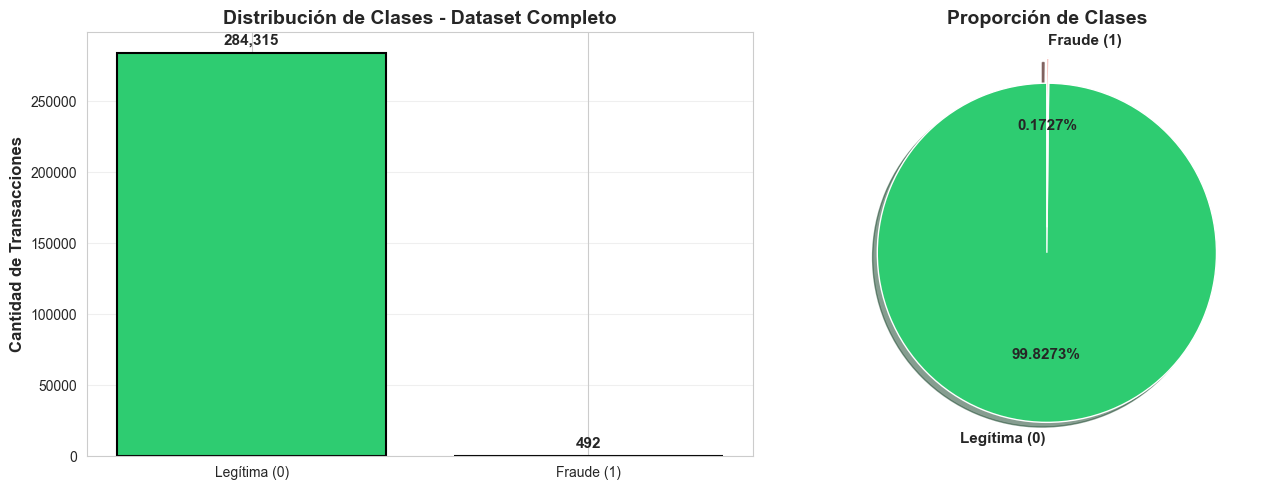

   ✓ Gráfico guardado en: output\train_test_comparison.png


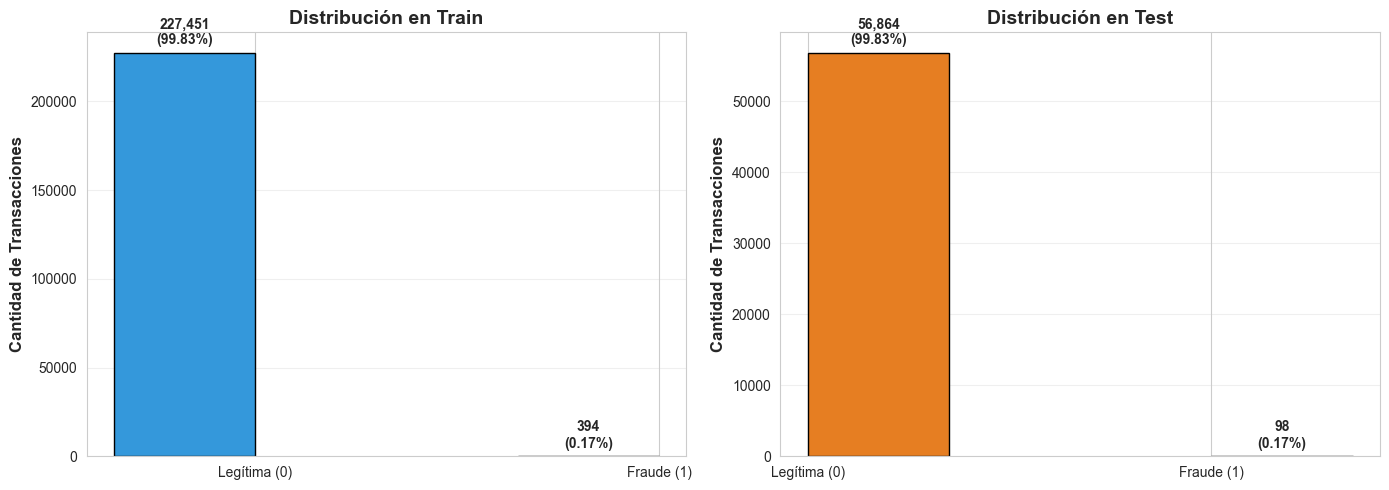


📋 RESUMEN EN FORMATO TABLA:
 Dataset  Total  Legítimas Legítimas %  Fraudes Fraudes %    Ratio
Completo 284807     284315    99.8273%      492   0.1727% 577.88:1
   Train 227845     227451    99.8271%      394   0.1729% 577.29:1
    Test  56962      56864    99.8280%       98   0.1720% 580.24:1


⚙️  Escalando features (Time, Amount)...
   ✓ Escalado completado sin data leakage

🚀 Entrenando modelo con GridSearchCV...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

✓ Entrenamiento completado
   Mejores parámetros:
      classifier__learning_rate: 0.1
      classifier__max_depth: 6
      classifier__n_estimators: 200
      classifier__scale_pos_weight: 1
   Mejor F2-score (CV): 0.7931

EVALUACIÓN CON THRESHOLD DEFAULT (threshold=0.5000)

📊 MÉTRICAS POR CLASE:
--------------------------------------------------------------------------------
Clase           Precision       Recall          F1-Score        Support   
------------------------------------------------------------

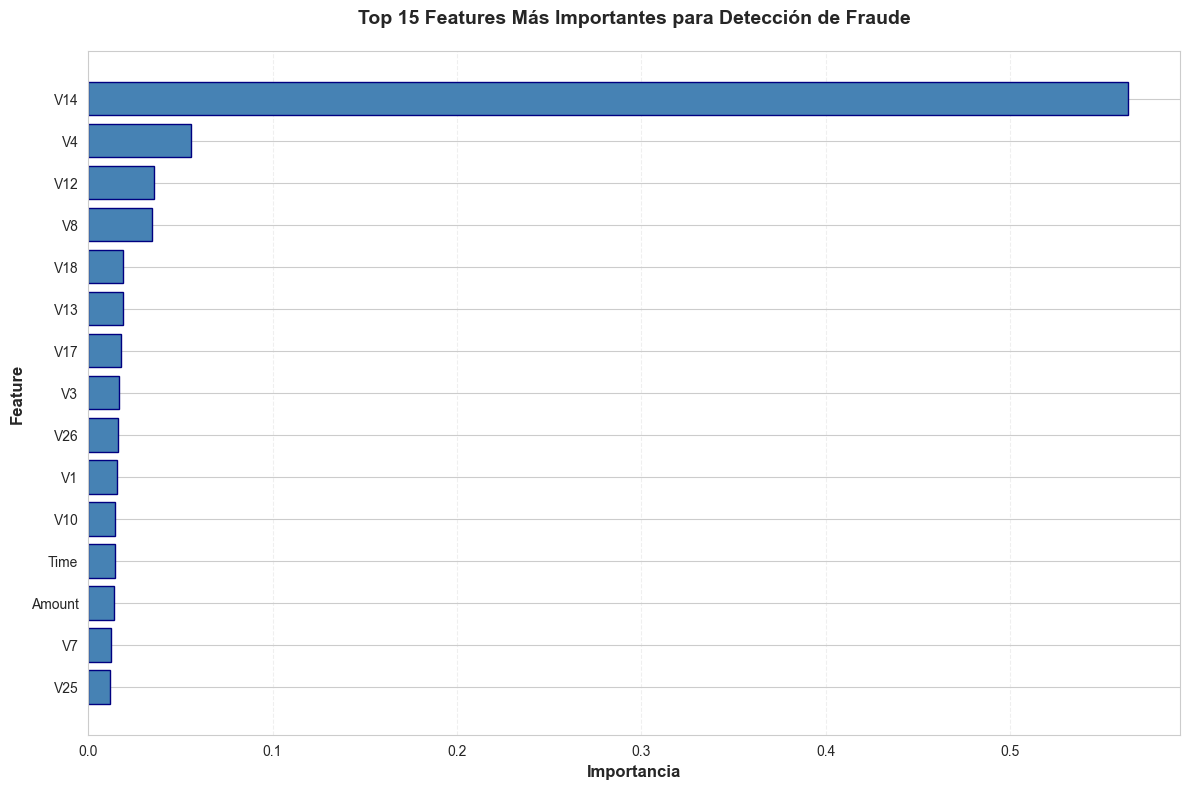

🏆 TOP 10 FEATURES MÁS IMPORTANTES:
--------------------------------------------------
    1. V14          → 0.563941
    2. V4           → 0.055509
    3. V12          → 0.035447
    4. V8           → 0.034823
    5. V18          → 0.019031
    6. V13          → 0.018895
    7. V17          → 0.017719
    8. V3           → 0.016535
    9. V26          → 0.016265
   10. V1           → 0.015837

💾 Guardando artefactos del modelo...
   ✓ Modelo guardado en: output\model_final.pkl
   ✓ Scaler guardado en: output\scaler.pkl
   ✓ Columnas guardadas en: output\model_columns.pkl
   ✓ Threshold guardado en: output\optimal_threshold.pkl

🔮 EJEMPLO DE PREDICCIÓN

   Transacción real:          LEGÍTIMA
   Probabilidad de fraude:    0.00%
   Clasificación:             LEGÍTIMA
   Nivel de confianza:        HIGH
   Threshold usado:           0.9721
   Recomendación:             ✅ APROBAR - Transacción normal

✅ PIPELINE COMPLETO EJECUTADO CON ÉXITO



In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, average_precision_score, 
    matthews_corrcoef, cohen_kappa_score, precision_recall_curve,
    fbeta_score, make_scorer
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from pathlib import Path
from typing import Dict, Tuple, Any

warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURACIÓN Y CONSTANTES
# ============================================================================

class Config:
    """Configuración centralizada del proyecto"""
    # Paths
    DATA_PATH = 'data/creditcard.csv'
    OUTPUT_DIR = Path('output')
    MODEL_PATH = OUTPUT_DIR / 'model_final.pkl'
    SCALER_PATH = OUTPUT_DIR / 'scaler.pkl'
    COLUMNS_PATH = OUTPUT_DIR / 'model_columns.pkl'
    THRESHOLD_PATH = OUTPUT_DIR / 'optimal_threshold.pkl'
    PLOT_IMPORTANCE_PATH = OUTPUT_DIR / 'feature_importance.png'
    PLOT_DISTRIBUTION_PATH = OUTPUT_DIR / 'class_distribution.png'
    PLOT_COMPARISON_PATH = OUTPUT_DIR / 'train_test_comparison.png'
    
    # Parámetros de modelo
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    N_SPLITS = 3
    N_JOBS = -1
    
    # Costos de negocio
    COST_FP = 1      # Costo de revisar transacción legítima
    COST_FN = 100    # Costo de permitir un fraude
    
    # Parámetros de visualización
    PLOT_DPI = 300
    TOP_N_FEATURES = 15
    
    @classmethod
    def setup(cls):
        """Crear directorios necesarios"""
        cls.OUTPUT_DIR.mkdir(exist_ok=True)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_colwidth', None)


# ============================================================================
# ANÁLISIS DE DISTRIBUCIÓN DE CLASES
# ============================================================================

class DataDistributionAnalyzer:
    """Clase para analizar y visualizar la distribución de clases"""
    
    def __init__(self, df: pd.DataFrame, y_train: pd.Series = None, y_test: pd.Series = None):
        self.df = df
        self.y_train = y_train
        self.y_test = y_test
        
    def print_full_dataset_stats(self):
        """Muestra estadísticas del dataset completo"""
        print("=" * 80)
        print("📊 ANÁLISIS DE DISTRIBUCIÓN DE CLASES - DATASET COMPLETO")
        print("=" * 80)
        
        total = len(self.df)
        fraud_count = (self.df['Class'] == 1).sum()
        legit_count = (self.df['Class'] == 0).sum()
        fraud_pct = (fraud_count / total) * 100
        legit_pct = (legit_count / total) * 100
        
        print(f"\n📈 Resumen General:")
        print(f"   Total de transacciones:     {total:>10,}")
        print(f"   Transacciones legítimas:    {legit_count:>10,}  ({legit_pct:>6.2f}%)")
        print(f"   Transacciones fraudulentas: {fraud_count:>10,}  ({fraud_pct:>6.2f}%)")
        print(f"   Ratio desbalanceo:          {legit_count/fraud_count:>10.2f}:1")
        
        # Tabla detallada
        print(f"\n📋 Tabla de Distribución:")
        print("-" * 80)
        print(f"{'Clase':<20} {'Etiqueta':<20} {'Cantidad':<15} {'Porcentaje':<15}")
        print("-" * 80)
        print(f"{'0':<20} {'Legítima':<20} {legit_count:>13,}   {legit_pct:>13.4f}%")
        print(f"{'1':<20} {'Fraude':<20} {fraud_count:>13,}   {fraud_pct:>13.4f}%")
        print("-" * 80)
        print(f"{'TOTAL':<20} {'':<20} {total:>13,}   {'100.0000%':>14}")
        print("-" * 80)
        print()
        
    def print_train_test_stats(self):
        """Muestra estadísticas de train y test"""
        if self.y_train is None or self.y_test is None:
            print("⚠️  No hay datos de train/test disponibles\n")
            return
            
        print("=" * 80)
        print("📊 ANÁLISIS DE DISTRIBUCIÓN - TRAIN vs TEST")
        print("=" * 80)
        
        # Train stats
        train_total = len(self.y_train)
        train_fraud = (self.y_train == 1).sum()
        train_legit = (self.y_train == 0).sum()
        train_fraud_pct = (train_fraud / train_total) * 100
        train_legit_pct = (train_legit / train_total) * 100
        
        # Test stats
        test_total = len(self.y_test)
        test_fraud = (self.y_test == 1).sum()
        test_legit = (self.y_test == 0).sum()
        test_fraud_pct = (test_fraud / test_total) * 100
        test_legit_pct = (test_legit / test_total) * 100
        
        print(f"\n🎯 Conjunto de ENTRENAMIENTO (Train):")
        print(f"   Total:                      {train_total:>10,}  (80% del dataset)")
        print(f"   Transacciones legítimas:    {train_legit:>10,}  ({train_legit_pct:>6.2f}%)")
        print(f"   Transacciones fraudulentas: {train_fraud:>10,}  ({train_fraud_pct:>6.2f}%)")
        
        print(f"\n🎯 Conjunto de PRUEBA (Test):")
        print(f"   Total:                      {test_total:>10,}  (20% del dataset)")
        print(f"   Transacciones legítimas:    {test_legit:>10,}  ({test_legit_pct:>6.2f}%)")
        print(f"   Transacciones fraudulentas: {test_fraud:>10,}  ({test_fraud_pct:>6.2f}%)")
        
        # Tabla comparativa
        print(f"\n📊 Tabla Comparativa:")
        print("-" * 90)
        print(f"{'Clase':<15} {'Train Count':<18} {'Train %':<12} {'Test Count':<18} {'Test %':<12}")
        print("-" * 90)
        print(f"{'Legítima (0)':<15} {train_legit:>16,}   {train_legit_pct:>10.4f}%  {test_legit:>16,}   {test_legit_pct:>10.4f}%")
        print(f"{'Fraude (1)':<15} {train_fraud:>16,}   {train_fraud_pct:>10.4f}%  {test_fraud:>16,}   {test_fraud_pct:>10.4f}%")
        print("-" * 90)
        print(f"{'TOTAL':<15} {train_total:>16,}   {'100.0000%':>11}  {test_total:>16,}   {'100.0000%':>11}")
        print("-" * 90)
        
        # Verificar estratificación
        diff_fraud = abs(train_fraud_pct - test_fraud_pct)
        diff_legit = abs(train_legit_pct - test_legit_pct)
        
        print(f"\n✅ Verificación de Estratificación:")
        print(f"   Diferencia % Fraude:        {diff_fraud:.4f}%  {'✓ Bien estratificado' if diff_fraud < 0.1 else '⚠️  Revisar'}")
        print(f"   Diferencia % Legítima:      {diff_legit:.4f}%  {'✓ Bien estratificado' if diff_legit < 0.1 else '⚠️  Revisar'}")
        print()
        
    def plot_distribution(self):
        """Genera gráficos de distribución de clases"""
        print("📊 Generando visualizaciones de distribución...")
        
        # Configurar estilo
        sns.set_style("whitegrid")
        
        # Figura 1: Distribución del dataset completo
        fig1, axes1 = plt.subplots(1, 2, figsize=(14, 5))
        
        # Gráfico de barras
        counts = self.df['Class'].value_counts().sort_index()
        colors = ['#2ecc71', '#e74c3c']
        axes1[0].bar(['Legítima (0)', 'Fraude (1)'], counts.values, color=colors, edgecolor='black', linewidth=1.5)
        axes1[0].set_ylabel('Cantidad de Transacciones', fontsize=12, fontweight='bold')
        axes1[0].set_title('Distribución de Clases - Dataset Completo', fontsize=14, fontweight='bold')
        axes1[0].grid(axis='y', alpha=0.3)
        
        # Añadir valores en las barras
        for i, v in enumerate(counts.values):
            axes1[0].text(i, v + max(counts.values)*0.02, f'{v:,}', ha='center', fontweight='bold', fontsize=11)
        
        # Gráfico de pastel
        percentages = (counts / counts.sum() * 100).values
        explode = (0.05, 0.1)
        axes1[1].pie(counts.values, labels=['Legítima (0)', 'Fraude (1)'], autopct='%1.4f%%',
                     colors=colors, explode=explode, shadow=True, startangle=90,
                     textprops={'fontsize': 11, 'fontweight': 'bold'})
        axes1[1].set_title('Proporción de Clases', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(Config.PLOT_DISTRIBUTION_PATH, dpi=Config.PLOT_DPI, bbox_inches='tight')
        print(f"   ✓ Gráfico guardado en: {Config.PLOT_DISTRIBUTION_PATH}")
        plt.show()
        
        # Figura 2: Comparación Train vs Test (si están disponibles)
        if self.y_train is not None and self.y_test is not None:
            fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))
            
            # Train
            train_counts = self.y_train.value_counts().sort_index()
            train_pct = (train_counts / train_counts.sum() * 100).values
            x = np.arange(2)
            width = 0.35
            
            axes2[0].bar(x - width/2, train_counts.values, width, label='Train', color='#3498db', edgecolor='black')
            axes2[0].set_ylabel('Cantidad de Transacciones', fontsize=12, fontweight='bold')
            axes2[0].set_title('Distribución en Train', fontsize=14, fontweight='bold')
            axes2[0].set_xticks(x)
            axes2[0].set_xticklabels(['Legítima (0)', 'Fraude (1)'])
            axes2[0].grid(axis='y', alpha=0.3)
            
            for i, v in enumerate(train_counts.values):
                axes2[0].text(i - width/2, v + max(train_counts.values)*0.02, 
                             f'{v:,}\n({train_pct[i]:.2f}%)', ha='center', fontweight='bold', fontsize=10)
            
            # Test
            test_counts = self.y_test.value_counts().sort_index()
            test_pct = (test_counts / test_counts.sum() * 100).values
            
            axes2[1].bar(x + width/2, test_counts.values, width, label='Test', color='#e67e22', edgecolor='black')
            axes2[1].set_ylabel('Cantidad de Transacciones', fontsize=12, fontweight='bold')
            axes2[1].set_title('Distribución en Test', fontsize=14, fontweight='bold')
            axes2[1].set_xticks(x)
            axes2[1].set_xticklabels(['Legítima (0)', 'Fraude (1)'])
            axes2[1].grid(axis='y', alpha=0.3)
            
            for i, v in enumerate(test_counts.values):
                axes2[1].text(i + width/2, v + max(test_counts.values)*0.02, 
                             f'{v:,}\n({test_pct[i]:.2f}%)', ha='center', fontweight='bold', fontsize=10)
            
            plt.tight_layout()
            plt.savefig(Config.PLOT_COMPARISON_PATH, dpi=Config.PLOT_DPI, bbox_inches='tight')
            print(f"   ✓ Gráfico guardado en: {Config.PLOT_COMPARISON_PATH}")
            plt.show()
        
        print()
    
    def generate_summary_dataframe(self) -> pd.DataFrame:
        """Genera un DataFrame resumen con todas las estadísticas"""
        total = len(self.df)
        fraud_count = (self.df['Class'] == 1).sum()
        legit_count = (self.df['Class'] == 0).sum()
        
        data = {
            'Dataset': ['Completo'],
            'Total': [total],
            'Legítimas': [legit_count],
            'Legítimas %': [f"{(legit_count/total)*100:.4f}%"],
            'Fraudes': [fraud_count],
            'Fraudes %': [f"{(fraud_count/total)*100:.4f}%"],
            'Ratio': [f"{legit_count/fraud_count:.2f}:1"]
        }
        
        if self.y_train is not None and self.y_test is not None:
            train_total = len(self.y_train)
            train_fraud = (self.y_train == 1).sum()
            train_legit = (self.y_train == 0).sum()
            
            test_total = len(self.y_test)
            test_fraud = (self.y_test == 1).sum()
            test_legit = (self.y_test == 0).sum()
            
            data['Dataset'].extend(['Train', 'Test'])
            data['Total'].extend([train_total, test_total])
            data['Legítimas'].extend([train_legit, test_legit])
            data['Legítimas %'].extend([f"{(train_legit/train_total)*100:.4f}%", f"{(test_legit/test_total)*100:.4f}%"])
            data['Fraudes'].extend([train_fraud, test_fraud])
            data['Fraudes %'].extend([f"{(train_fraud/train_total)*100:.4f}%", f"{(test_fraud/test_total)*100:.4f}%"])
            data['Ratio'].extend([f"{train_legit/train_fraud:.2f}:1", f"{test_legit/test_fraud:.2f}:1"])
        
        df_summary = pd.DataFrame(data)
        return df_summary


# ============================================================================
# FUNCIONES DE PREPROCESAMIENTO
# ============================================================================

def load_and_split_data(filepath: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Carga datos y realiza split estratificado
    
    Args:
        filepath: Ruta al archivo CSV
        
    Returns:
        Tupla (df, X_train, X_test, y_train, y_test)
    """
    print("📂 Cargando datos...")
    df = pd.read_csv(filepath)
    print(f"   ✓ Datos cargados: {len(df):,} transacciones\n")
    
    X = df.drop('Class', axis=1)
    y = df['Class']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=Config.TEST_SIZE, 
        random_state=Config.RANDOM_STATE, 
        stratify=y
    )
    
    return df, X_train, X_test, y_train, y_test


def scale_features(X_train: pd.DataFrame, X_test: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, StandardScaler]:
    """
    Escala Time y Amount sin data leakage
    
    Args:
        X_train: Features de entrenamiento
        X_test: Features de prueba
        
    Returns:
        Tupla (X_train_scaled, X_test_scaled, scaler)
    """
    print("⚙️  Escalando features (Time, Amount)...")
    
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    # Ajustar SOLO en train, transformar ambos
    X_train_scaled[['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])
    X_test_scaled[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])
    
    print("   ✓ Escalado completado sin data leakage\n")
    
    return X_train_scaled, X_test_scaled, scaler


# ============================================================================
# ENTRENAMIENTO Y OPTIMIZACIÓN
# ============================================================================

def create_pipeline() -> ImbPipeline:
    """Crea pipeline con SMOTE y XGBoost"""
    return ImbPipeline([
        ('smote', SMOTE(random_state=Config.RANDOM_STATE)),
        ('classifier', XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=Config.RANDOM_STATE,
            n_jobs=Config.N_JOBS
        ))
    ])


def get_param_grid(y_train: pd.Series) -> Dict[str, list]:
    """Define grid de hiperparámetros"""
    scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
    
    return {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [4, 6],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__scale_pos_weight': [1, scale_pos_weight]
    }


def train_model(X_train: pd.DataFrame, y_train: pd.Series) -> ImbPipeline:
    """
    Entrena modelo con GridSearchCV y validación cruzada
    
    Args:
        X_train: Features de entrenamiento escaladas
        y_train: Labels de entrenamiento
        
    Returns:
        Mejor modelo entrenado
    """
    print("🚀 Entrenando modelo con GridSearchCV...")
    
    pipeline = create_pipeline()
    param_grid = get_param_grid(y_train)
    
    # F2-score para priorizar recall
    f2_scorer = make_scorer(fbeta_score, beta=2)
    
    cv = StratifiedKFold(n_splits=Config.N_SPLITS, shuffle=True, random_state=Config.RANDOM_STATE)
    
    grid = GridSearchCV(
        pipeline, 
        param_grid, 
        scoring=f2_scorer,
        cv=cv, 
        n_jobs=Config.N_JOBS, 
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    print(f"\n✓ Entrenamiento completado")
    print(f"   Mejores parámetros:")
    for param, value in grid.best_params_.items():
        print(f"      {param}: {value}")
    print(f"   Mejor F2-score (CV): {grid.best_score_:.4f}\n")
    
    return grid.best_estimator_


def optimize_threshold(y_test: pd.Series, y_proba: np.ndarray) -> Tuple[float, np.ndarray]:
    """
    Encuentra threshold óptimo maximizando F2-score
    
    Args:
        y_test: Labels reales
        y_proba: Probabilidades predichas
        
    Returns:
        Tupla (optimal_threshold, y_pred_optimal)
    """
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    
    # Calcular F2-score para cada threshold
    with np.errstate(divide='ignore', invalid='ignore'):
        f2_scores = np.where(
            (4 * precision + recall) == 0,
            0,
            (5 * precision * recall) / (4 * precision + recall)
        )
    
    optimal_idx = np.argmax(f2_scores)
    optimal_threshold = thresholds[optimal_idx]
    y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
    
    return optimal_threshold, y_pred_optimal


# ============================================================================
# EVALUACIÓN Y MÉTRICAS
# ============================================================================

class ModelEvaluator:
    """Clase para evaluar y mostrar métricas del modelo"""
    
    def __init__(self, y_test: pd.Series, y_proba: np.ndarray):
        self.y_test = y_test
        self.y_proba = y_proba
        
    def evaluate(self, y_pred: np.ndarray, threshold: float, title: str):
        """Evalúa modelo con threshold dado"""
        cm = confusion_matrix(self.y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        # Calcular métricas
        metrics = self._calculate_metrics(tn, fp, fn, tp)
        
        # Mostrar resultados
        self._print_header(title, threshold)
        self._print_class_metrics(metrics, tn, fp, fn, tp)
        self._print_confusion_matrix(tn, fp, fn, tp)
        self._print_error_details(tn, fp, fn, tp)
        self._print_global_metrics()
        self._print_cost_analysis(fp, fn)
        
        return metrics, (tn, fp, fn, tp)
    
    def _calculate_metrics(self, tn: int, fp: int, fn: int, tp: int) -> Dict[str, float]:
        """Calcula todas las métricas"""
        # Métricas por clase
        recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision_0 = tn / (tn + fn) if (tn + fn) > 0 else 0
        f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
        
        recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
        
        accuracy = (tn + tp) / (tn + fp + fn + tp)
        
        return {
            'precision_0': precision_0, 'recall_0': recall_0, 'f1_0': f1_0,
            'precision_1': precision_1, 'recall_1': recall_1, 'f1_1': f1_1,
            'accuracy': accuracy
        }
    
    def _print_header(self, title: str, threshold: float):
        """Imprime encabezado de evaluación"""
        print("=" * 80)
        print(f"{title} (threshold={threshold:.4f})")
        print("=" * 80)
    
    def _print_class_metrics(self, metrics: Dict, tn: int, fp: int, fn: int, tp: int):
        """Imprime tabla de métricas por clase"""
        print("\n📊 MÉTRICAS POR CLASE:")
        print("-" * 80)
        print(f"{'Clase':<15} {'Precision':<15} {'Recall':<15} {'F1-Score':<15} {'Support':<10}")
        print("-" * 80)
        print(f"{'0 (Legítima)':<15} {metrics['precision_0']:<15.4f} {metrics['recall_0']:<15.4f} {metrics['f1_0']:<15.4f} {tn+fn:<10,}")
        print(f"{'1 (Fraude)':<15} {metrics['precision_1']:<15.4f} {metrics['recall_1']:<15.4f} {metrics['f1_1']:<15.4f} {tp+fn:<10,}")
        print("-" * 80)
        print(f"{'Accuracy':<15} {'':<15} {'':<15} {metrics['accuracy']:<15.4f} {len(self.y_test):<10,}")
        print("-" * 80)
    
    def _print_confusion_matrix(self, tn: int, fp: int, fn: int, tp: int):
        """Imprime matriz de confusión"""
        print("\n🎯 MATRIZ DE CONFUSIÓN:")
        print("-" * 50)
        print(f"{'':>25} {'Predicción'}")
        print(f"{'':>25} {'Legítima':<15} {'Fraude':<15}")
        print("-" * 50)
        print(f"{'Real Legítima':>25} {tn:>12,}   {fp:>12,}")
        print(f"{'Real Fraude':>25} {fn:>12,}   {tp:>12,}")
        print("-" * 50)
    
    def _print_error_details(self, tn: int, fp: int, fn: int, tp: int):
        """Imprime detalles de errores"""
        print("\n⚠️  DETALLE DE ERRORES:")
        print(f"   True Negatives (TN):   {tn:>8,}  ✓ Legítimas correctamente clasificadas")
        print(f"   False Positives (FP):  {fp:>8,}  ✗ Legítimas marcadas como fraude")
        print(f"   False Negatives (FN):  {fn:>8,}  ✗ Fraudes no detectados (CRÍTICO)")
        print(f"   True Positives (TP):   {tp:>8,}  ✓ Fraudes correctamente detectados")
    
    def _print_global_metrics(self):
        """Imprime métricas globales"""
        y_pred_default = (self.y_proba >= 0.5).astype(int)
        
        print("\n🌐 MÉTRICAS GLOBALES:")
        print(f"   ROC-AUC Score:              {roc_auc_score(self.y_test, self.y_proba):.4f}")
        print(f"   PR-AUC (Avg Precision):     {average_precision_score(self.y_test, self.y_proba):.4f}")
        print(f"   Matthews Corr. Coef (MCC):  {matthews_corrcoef(self.y_test, y_pred_default):.4f}")
        print(f"   Cohen's Kappa:              {cohen_kappa_score(self.y_test, y_pred_default):.4f}")
    
    def _print_cost_analysis(self, fp: int, fn: int):
        """Imprime análisis de costos"""
        total_cost = (fp * Config.COST_FP) + (fn * Config.COST_FN)
        
        print(f"\n💰 ANÁLISIS DE COSTOS:")
        print(f"   Costo por Falso Positivo:   ${Config.COST_FP:>8,}  (revisar transacción)")
        print(f"   Costo por Falso Negativo:   ${Config.COST_FN:>8,}  (permitir fraude)")
        print(f"   Total Falsos Positivos:     {fp:>8,}  → ${fp * Config.COST_FP:>10,}")
        print(f"   Total Falsos Negativos:     {fn:>8,}  → ${fn * Config.COST_FN:>10,}")
        print(f"   {'COSTO TOTAL:':<30} ${total_cost:>10,}")
        print()


def compare_thresholds(metrics_default: Dict, cm_default: Tuple, 
                       metrics_optimal: Dict, cm_optimal: Tuple,
                       optimal_threshold: float):
    """Compara resultados entre threshold default y óptimo"""
    tn_def, fp_def, fn_def, tp_def = cm_default
    tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal
    
    cost_default = (fp_def * Config.COST_FP) + (fn_def * Config.COST_FN)
    cost_optimal = (fp_opt * Config.COST_FP) + (fn_opt * Config.COST_FN)
    cost_reduction = cost_default - cost_optimal
    cost_reduction_pct = (cost_reduction / cost_default * 100) if cost_default > 0 else 0
    
    print("=" * 80)
    print(f"📈 COMPARACIÓN: Threshold 0.5 vs {optimal_threshold:.4f}")
    print("=" * 80)
    
    print("\n🔄 CAMBIOS EN ERRORES:")
    print(f"   False Positives:  {fp_def:>6,} → {fp_opt:>6,}  ({fp_opt - fp_def:+6,})")
    print(f"   False Negatives:  {fn_def:>6,} → {fn_opt:>6,}  ({fn_opt - fn_def:+6,})")
    
    print("\n💵 IMPACTO EN COSTOS:")
    print(f"   Costo con threshold 0.5:        ${cost_default:>10,}")
    print(f"   Costo con threshold {optimal_threshold:.4f}:     ${cost_optimal:>10,}")
    print(f"   {'Reducción de costo:':<30} ${cost_reduction:>10,} ({cost_reduction_pct:+.1f}%)")
    print()


# ============================================================================
# VISUALIZACIÓN
# ============================================================================

def plot_feature_importance(model: ImbPipeline, feature_names: pd.Index, 
                           top_n: int = Config.TOP_N_FEATURES):
    """
    Genera gráfico de importancia de features
    
    Args:
        model: Modelo entrenado
        feature_names: Nombres de las features
        top_n: Número de features a mostrar
    """
    print(f"📊 Generando gráfico de importancia de features...")
    
    classifier = model.named_steps['classifier']
    importance = classifier.feature_importances_
    
    # Top N features
    indices = np.argsort(importance)[-top_n:]
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(indices)), importance[indices], color='steelblue', edgecolor='navy')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Importancia', fontsize=12, fontweight='bold')
    plt.ylabel('Feature', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Features Más Importantes para Detección de Fraude', 
              fontsize=14, fontweight='bold', pad=20)
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    plt.savefig(Config.PLOT_IMPORTANCE_PATH, dpi=Config.PLOT_DPI, bbox_inches='tight')
    print(f"   ✓ Gráfico guardado en: {Config.PLOT_IMPORTANCE_PATH}\n")
    plt.show()
    
    # Mostrar top 10 en consola
    print("🏆 TOP 10 FEATURES MÁS IMPORTANTES:")
    print("-" * 50)
    top_10_indices = indices[-10:][::-1]
    for i, idx in enumerate(top_10_indices, 1):
        print(f"   {i:>2}. {feature_names[idx]:<12} → {importance[idx]:.6f}")
    print()


# ============================================================================
# PERSISTENCIA Y PREDICCIÓN
# ============================================================================

def save_artifacts(model: ImbPipeline, scaler: StandardScaler, 
                  columns: list, threshold: float):
    """Guarda todos los artefactos del modelo"""
    print("💾 Guardando artefactos del modelo...")
    
    joblib.dump(model, Config.MODEL_PATH)
    joblib.dump(scaler, Config.SCALER_PATH)
    joblib.dump(columns, Config.COLUMNS_PATH)
    joblib.dump(threshold, Config.THRESHOLD_PATH)
    
    print(f"   ✓ Modelo guardado en: {Config.MODEL_PATH}")
    print(f"   ✓ Scaler guardado en: {Config.SCALER_PATH}")
    print(f"   ✓ Columnas guardadas en: {Config.COLUMNS_PATH}")
    print(f"   ✓ Threshold guardado en: {Config.THRESHOLD_PATH}\n")


def load_artifacts() -> Tuple[ImbPipeline, StandardScaler, list, float]:
    """Carga todos los artefactos del modelo"""
    model = joblib.load(Config.MODEL_PATH)
    scaler = joblib.load(Config.SCALER_PATH)
    columns = joblib.load(Config.COLUMNS_PATH)
    threshold = joblib.load(Config.THRESHOLD_PATH)
    
    return model, scaler, columns, threshold


class FraudPredictor:
    """Clase para realizar predicciones de fraude"""
    
    def __init__(self, model: ImbPipeline, scaler: StandardScaler, 
                 columns: list, threshold: float):
        self.model = model
        self.scaler = scaler
        self.columns = columns
        self.threshold = threshold
    
    def predict(self, transaction_dict: Dict[str, float]) -> Dict[str, Any]:
        """
        Predice si una transacción es fraudulenta
        
        Args:
            transaction_dict: Diccionario con features de la transacción
                             Debe incluir: Time, V1-V28, Amount
        
        Returns:
            Diccionario con resultado de la predicción
        """
        # Validar entrada
        self._validate_input(transaction_dict)
        
        # Preparar datos
        df_transaction = pd.DataFrame([transaction_dict])[self.columns]
        
        # Escalar Time y Amount
        df_transaction[['Time', 'Amount']] = self.scaler.transform(
            df_transaction[['Time', 'Amount']]
        )
        
        # Predicción
        fraud_prob = self.model.predict_proba(df_transaction)[0, 1]
        is_fraud = fraud_prob >= self.threshold
        
        # Análisis de confianza y recomendación
        confidence = self._get_confidence_level(fraud_prob)
        recommendation = self._get_recommendation(is_fraud, fraud_prob)
        
        return {
            'fraud_probability': round(float(fraud_prob), 4),
            'is_fraud': bool(is_fraud),
            'confidence': confidence,
            'threshold_used': round(float(self.threshold), 4),
            'recommendation': recommendation
        }
    
    def _validate_input(self, transaction_dict: Dict[str, float]):
        """Valida que la entrada tenga todas las columnas necesarias"""
        required_cols = set(self.columns)
        provided_cols = set(transaction_dict.keys())
        
        if not required_cols.issubset(provided_cols):
            missing = required_cols - provided_cols
            raise ValueError(f"❌ Faltan las siguientes columnas: {missing}")
    
    def _get_confidence_level(self, fraud_prob: float) -> str:
        """Determina nivel de confianza basado en probabilidad"""
        if fraud_prob > 0.85 or fraud_prob < 0.15:
            return 'high'
        elif fraud_prob > 0.65 or fraud_prob < 0.35:
            return 'medium'
        else:
            return 'low'
    
    def _get_recommendation(self, is_fraud: bool, fraud_prob: float) -> str:
        """Genera recomendación de acción"""
        if is_fraud and fraud_prob > 0.9:
            return "🚫 BLOQUEAR - Alta probabilidad de fraude"
        elif is_fraud:
            return "⚠️  REVISAR MANUALMENTE - Posible fraude"
        elif fraud_prob > 0.3:
            return "👁️  MONITOREAR - Riesgo moderado"
        else:
            return "✅ APROBAR - Transacción normal"


def demo_prediction(predictor: FraudPredictor, X_test: pd.DataFrame, 
                   y_test: pd.Series, index: int = 10):
    """Demuestra predicción con una transacción de ejemplo"""
    print("=" * 80)
    print("🔮 EJEMPLO DE PREDICCIÓN")
    print("=" * 80)
    
    sample_transaction = X_test.iloc[index].to_dict()
    result = predictor.predict(sample_transaction)
    actual_label = "FRAUDE" if y_test.iloc[index] == 1 else "LEGÍTIMA"
    
    print(f"\n   Transacción real:          {actual_label}")
    print(f"   Probabilidad de fraude:    {result['fraud_probability']:.2%}")
    print(f"   Clasificación:             {'FRAUDE' if result['is_fraud'] else 'LEGÍTIMA'}")
    print(f"   Nivel de confianza:        {result['confidence'].upper()}")
    print(f"   Threshold usado:           {result['threshold_used']:.4f}")
    print(f"   Recomendación:             {result['recommendation']}")
    print()


# ============================================================================
# PIPELINE PRINCIPAL
# ============================================================================

def main():
    """Ejecuta pipeline completo de detección de fraude"""
    print("\n" + "=" * 80)
    print("🔒 SISTEMA DE DETECCIÓN DE FRAUDE EN TARJETAS DE CRÉDITO")
    print("=" * 80 + "\n")
    
    # Configuración inicial
    Config.setup()
    
    # 1. Carga y preprocesamiento
    df, X_train, X_test, y_train, y_test = load_and_split_data(Config.DATA_PATH)
    
    # 2. ANÁLISIS DE DISTRIBUCIÓN DE CLASES
    analyzer = DataDistributionAnalyzer(df, y_train, y_test)
    
    # Mostrar estadísticas completas
    analyzer.print_full_dataset_stats()
    analyzer.print_train_test_stats()
    
    # Generar visualizaciones
    analyzer.plot_distribution()
    
    # Generar DataFrame resumen
    df_summary = analyzer.generate_summary_dataframe()
    print("📋 RESUMEN EN FORMATO TABLA:")
    print(df_summary.to_string(index=False))
    print("\n")
    
    # 3. Escalado de features
    X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)
    
    # 4. Entrenamiento
    best_model = train_model(X_train_scaled, y_train)
    
    # 5. Predicciones
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    y_pred_default = best_model.predict(X_test_scaled)
    
    # 6. Evaluación con threshold default
    evaluator = ModelEvaluator(y_test, y_proba)
    metrics_default, cm_default = evaluator.evaluate(
        y_pred_default, 0.5, "EVALUACIÓN CON THRESHOLD DEFAULT"
    )
    
    # 7. Optimización de threshold
    print("🎯 Optimizando threshold...")
    optimal_threshold, y_pred_optimal = optimize_threshold(y_test, y_proba)
    print(f"   ✓ Threshold óptimo encontrado: {optimal_threshold:.4f}\n")
    
    # 8. Evaluación con threshold óptimo
    metrics_optimal, cm_optimal = evaluator.evaluate(
        y_pred_optimal, optimal_threshold, "EVALUACIÓN CON THRESHOLD OPTIMIZADO"
    )
    
    # 9. Comparación
    compare_thresholds(metrics_default, cm_default, metrics_optimal, cm_optimal, optimal_threshold)
    
    # 10. Feature importance
    plot_feature_importance(best_model, X_train_scaled.columns)
    
    # 11. Guardar artefactos
    save_artifacts(best_model, scaler, X_train_scaled.columns.tolist(), optimal_threshold)
    
    # 12. Demo de predicción
    predictor = FraudPredictor(best_model, scaler, X_train_scaled.columns.tolist(), optimal_threshold)
    demo_prediction(predictor, X_test_scaled, y_test)
    
    print("=" * 80)
    print("✅ PIPELINE COMPLETO EJECUTADO CON ÉXITO")
    print("=" * 80 + "\n")


if __name__ == "__main__":
    main()